# Progetto: NFL Combine

**Programmazione di Applicazioni Data Intensive**<br />
Sviluppato da Leon Baiocchi e Alessandro Zanzi.

In [2]:
# setup e test librerie
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

## 1A) Caso di studio: Draft result prediction
- Dati i risultati del NFL Combine tra gli anni 2009 e 2019, sfrutteremo i dati raccolti sui vari giocatori con l'intent di addestrare il modello in modo da predirre se un giocatore verrà scelto o meno al Draft.
- Da ciascun giocatore si possono estrarre delle caratteristiche:
    - età, peso, velocità sulle 40 yard, benchpress max reps, vertical jump result, ...
- Dal dataset con i risultati del NFL Combine possiamo estrarre ciascuna di queste feature sulla base delle quali il draft avrà esito positivo o negativo.

In [3]:
# pip install kaggle #decomment if already installed.

- Utilizziamo il dataset [NFL Combine - Performance Data(2009 - 2019)](https://www.kaggle.com/datasets/redlineracer/nfl-combine-performance-data-2009-2019), in cui ogni riga contiene i dati delle performance di un dato giocatore.
- Per importare il dataset è opportuno aver installato `kaggle` e aver settato il proprio token per l'API
- Dopodichè si può passare al download dell'intero dataset in formato `csv`

In [4]:
import os.path
if not os.path.exists('NFL'+'.csv'):
    import kaggle
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('redlineracer/nfl-combine-performance-data-2009-2019', unzip=True)

In [5]:
dataset = pd.read_csv('NFL.csv', index_col=0)

In [6]:
dataset.head(6)

,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Drafted..tm.rnd.yr.,BMI,Player_Type,Position_Type,Position,Drafted
Year,,,,,,,,,,,,,,,,,
2009,Beanie Wells\WellCh00,20.0,Ohio St.,1.8542,106.594207,4.38,85.09,25.0,325.12,NaN,NaN,Arizona Cardinals / 1st / 31st pick / 2009,31.004194,offense,backs_receivers,RB,Yes
2009,Will Davis\DaviWi99,22.0,Illinois,1.8796,118.387609,4.84,83.82,27.0,292.10,7.38,4.45,Arizona Cardinals / 6th / 204th pick / 2009,33.510073,defense,defensive_lineman,DE,Yes
2009,Herman Johnson\JohnHe23,24.0,LSU,2.0066,165.107623,5.50,NaN,21.0,NaN,NaN,NaN,Arizona Cardinals / 5th / 167th pick / 2009,41.005821,offense,offensive_lineman,OG,Yes
2009,Rashad Johnson\JohnRa98,23.0,Alabama,1.8034,92.079251,4.49,93.98,15.0,304.80,7.09,4.23,Arizona Cardinals / 3rd / 95th pick / 2009,28.312463,defense,defensive_back,FS,Yes
2009,Cody Brown\BrowCo96,22.0,Connecticut,1.8796,110.676538,4.76,92.71,26.0,304.80,7.10,4.40,Arizona Cardinals / 2nd / 63rd pick / 2009,31.327425,defense,line_backer,OLB,Yes
2009,Trevor Canfield\CanfTr20,23.0,Cincinnati,1.9304,139.252858,5.28,NaN,29.0,NaN,NaN,NaN,Arizona Cardinals / 7th / 254th pick / 2009,37.368830,offense,offensive_lineman,OG,Yes


In [7]:
dataset.tail(6)

,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Drafted..tm.rnd.yr.,BMI,Player_Type,Position_Type,Position,Drafted
Year,,,,,,,,,,,,,,,,,
2019,Keelan Doss,NaN,UC Davis,1.8796,95.707990,NaN,NaN,8.0,NaN,NaN,NaN,NaN,27.090519,offense,backs_receivers,WR,No
2019,Xavier Crawford,NaN,Central Michigan,1.8034,84.821773,4.48,95.25,11.0,NaN,NaN,NaN,NaN,26.080939,defense,defensive_back,CB,No
2019,Jordan Brown,NaN,South Dakota St.,1.8288,91.172066,4.51,100.33,13.0,325.12,NaN,NaN,NaN,27.260221,defense,defensive_back,CB,No
2019,Corey Ballentine,NaN,Washburn,1.8034,88.904105,4.47,100.33,15.0,342.90,6.82,4.14,NaN,27.336171,defense,defensive_back,CB,No
2019,Ugo Amadi,NaN,Oregon,1.7526,90.264882,4.51,82.55,18.0,292.10,7.21,4.19,NaN,29.386861,defense,defensive_back,S,No
2019,Nasir Adderley,NaN,Delaware,1.8288,93.440028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.938336,defense,defensive_back,S,No


## Analisi variabili dataset:

- `Year`: anno in cui si è svolto il Combine training, è indice del dataset;
- `Player`: nome/id del giocatore;
- `Age`: età del giocatore;
- `School`: scuola frequentata;
- `Height`: altezza in metri(m);
- `Weight`: peso in kilogrammi(Kg);
- `Sprint_40yd`: tempo scatto sulle 40 yard in secondi;
- `Vertical_Jump`: salto verticale in centimetri(cm);
- `Bench_Press_Reps`: maggior numero di ripetizioni su panca piana con 102.1 Kg;
- `Broad_Jump`: salto in lungo in centimetri(cm);
- `Agility_3cone`: tempo migliore percorso a coni in secondi;
- `Shuttle`: scivolamento laterale in secondi;
- `Drafted..tm.rnd.yr`: il team che ha scelto il giocatore, a quale round del draft, con quale scelta(in numero) e l'anno del draft;
- `BMI`: Body Mass Index (Kg/m³);
- `Player_Type`: tipo di giocatore(difensivo o offensivo);
- `Position_Type`: classificazione ampia della posizione di gioco degli atleti;
- `Position`: posizione del giocatore;
- `Drafted`: esito del draft;
<hr />
Come si può notare anche dalla cella qui sotto, il numero di variabili è 17 mentre le istanze totali sono 3477.

In [8]:
dataset.shape

(3477, 17)

- Nell'analisi delle osservazioni ci siamo resi conto che alcune variabili possono essere scartate in quanto <i>non rilevanti</i> al fine di determinare l'esito del draft.
- Queste variabili sono le seguenti:
    - `Player`, `Age`, `Drafted..tm..rnd.yr`, `Player_Type`, `Position_Type` # TODO: Explain why
- Per quanto riguarda la variabile da predire, la nostra scelta è ricaduta su `Drafted`, una variabile discreta binaria che indica l'esito del draft, positivo o negativo, in particolare 'Yes' o 'No'.
- Iniziamo quindi a raccogliere le varie feature insieme.

In [9]:
features = [
    "School", "Height", 
    "Weight", "Sprint_40yd",
    "Vertical_Jump", "Bench_Press_Reps", 
    "Broad_Jump", "Agility_3cone",
    "Shuttle", "BMI", "Position"
]

In [34]:
target = "Drafted"

## 1B) Analisi esplorativa dei dati:
- Calcolo numero di drafted e non-drafted.

In [10]:
dataset["Drafted"].value_counts()

Yes    2254
No     1223
Name: Drafted, dtype: int64

In [11]:
dataset["Drafted"].value_counts(normalize=True)

Yes    0.64826
No     0.35174
Name: Drafted, dtype: float64

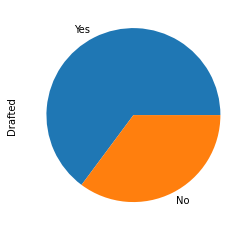

In [25]:
dataset["Drafted"].value_counts().plot.pie();

- Analisi dei dati con distribuzioni, medie, stddev, percentili, numero valori distinti delle feature.

In [13]:
dataset.iloc[:, :].describe()

,Age,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,BMI
count,2927.000000,3477.000000,3477.000000,3303.000000,2780.000000,2572.000000,2749.000000,2260.000000,2337.000000,3477.000000
mean,21.983259,1.873968,109.746393,4.769080,83.392403,20.241058,291.629698,7.237416,4.403843,31.074417
std,0.969490,0.067494,20.483780,0.301477,10.678403,6.497600,23.960879,0.410230,0.265224,4.438279
min,18.000000,1.651000,67.585263,4.220000,44.450000,2.000000,198.120000,6.280000,3.810000,21.609798
25%,21.000000,1.828800,92.986436,4.530000,76.200000,15.000000,276.860000,6.940000,4.200000,27.475641
50%,22.000000,1.879600,104.779837,4.690000,83.820000,20.000000,294.640000,7.140000,4.360000,30.122626
75%,23.000000,1.930400,125.645087,4.960000,90.170000,25.000000,307.340000,7.490000,4.560000,34.038647
max,28.000000,2.082800,167.375585,6.000000,114.300000,49.000000,373.380000,9.040000,5.560000,44.680097


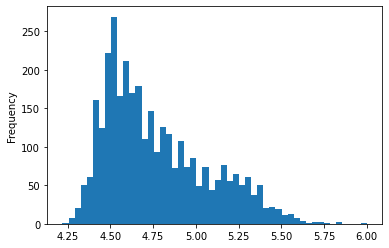

In [14]:
dataset["Sprint_40yd"].plot.hist(bins=50);

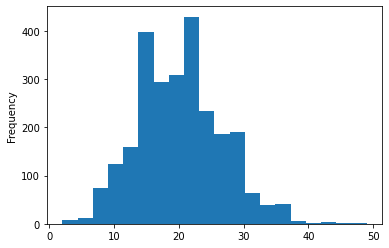

In [15]:
dataset["Bench_Press_Reps"].plot.hist(bins=20);

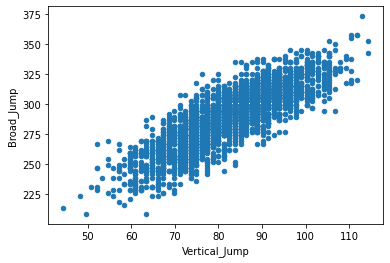

In [16]:
dataset.plot.scatter("Vertical_Jump", "Broad_Jump");

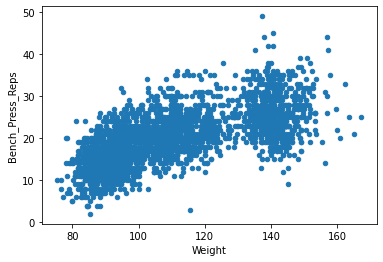

In [17]:
dataset.plot.scatter("Weight", "Bench_Press_Reps");

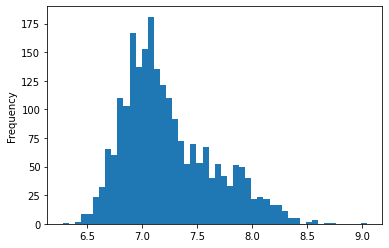

In [18]:
dataset["Agility_3cone"].plot.hist(bins=50);

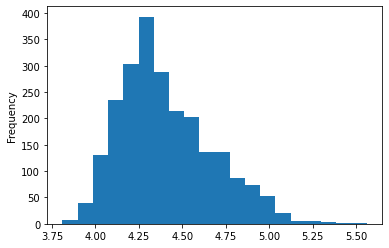

In [19]:
dataset["Shuttle"].plot.hist(bins=20);

- Numero valori distinti delle feature.

In [45]:
not_features = [x for x in dataset.columns.to_list() if x not in features and x != "Drafted"]
features_data = dataset.drop(columns=not_features)
features_data

,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,BMI,Position,Drafted
Year,,,,,,,,,,,,
2009,Ohio St.,1.8542,106.594207,4.38,85.09,25.0,325.12,NaN,NaN,31.004194,RB,Yes
2009,Illinois,1.8796,118.387609,4.84,83.82,27.0,292.10,7.38,4.45,33.510073,DE,Yes
2009,LSU,2.0066,165.107623,5.50,NaN,21.0,NaN,NaN,NaN,41.005821,OG,Yes
2009,Alabama,1.8034,92.079251,4.49,93.98,15.0,304.80,7.09,4.23,28.312463,FS,Yes
2009,Connecticut,1.8796,110.676538,4.76,92.71,26.0,304.80,7.10,4.40,31.327425,OLB,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
2019,Central Michigan,1.8034,84.821773,4.48,95.25,11.0,NaN,NaN,NaN,26.080939,CB,No
2019,South Dakota St.,1.8288,91.172066,4.51,100.33,13.0,325.12,NaN,NaN,27.260221,CB,No
2019,Washburn,1.8034,88.904105,4.47,100.33,15.0,342.90,6.82,4.14,27.336171,CB,No


In [54]:
for col in range(len(features_data.columns.to_list())-1):
    separator = "----------------------------------\n"
    print(separator + f'{features_data.columns.to_list()[col]}\n')
    print(features_data.iloc[:, col].value_counts())
    

----------------------------------
School

Alabama                   101
LSU                        95
Ohio St.                   82
USC                        79
Florida                    76
                         ... 
North Carolina Central      1
Hobart & William Smith      1
NW State (LA)               1
Navy                        1
Washburn                    1
Name: School, Length: 253, dtype: int64
----------------------------------
Height

1.9050    480
1.8542    435
1.8796    432
1.8288    410
1.9304    408
1.9558    337
1.8034    311
1.7780    219
1.9812    159
1.7526    129
2.0066     65
1.7272     45
1.7018     20
2.0320     19
1.6764      5
1.6510      1
2.0574      1
2.0828      1
Name: Height, dtype: int64
----------------------------------
Weight

95.707990     54
92.986436     48
90.264882     47
88.450512     46
96.615175     46
              ..
159.664514     1
165.107623     1
74.842741      1
73.935556      1
72.574779      1
Name: Weight, Length: 194, dtype: i

In [21]:
not_features_data = dataset.drop(columns=features).drop(columns='Drafted')
not_features_data

,Player,Age,Drafted..tm.rnd.yr.,Player_Type,Position_Type
Year,,,,,
2009,Beanie Wells\WellCh00,20.0,Arizona Cardinals / 1st / 31st pick / 2009,offense,backs_receivers
2009,Will Davis\DaviWi99,22.0,Arizona Cardinals / 6th / 204th pick / 2009,defense,defensive_lineman
2009,Herman Johnson\JohnHe23,24.0,Arizona Cardinals / 5th / 167th pick / 2009,offense,offensive_lineman
2009,Rashad Johnson\JohnRa98,23.0,Arizona Cardinals / 3rd / 95th pick / 2009,defense,defensive_back
2009,Cody Brown\BrowCo96,22.0,Arizona Cardinals / 2nd / 63rd pick / 2009,defense,line_backer
...,...,...,...,...,...
2019,Xavier Crawford,NaN,NaN,defense,defensive_back
2019,Jordan Brown,NaN,NaN,defense,defensive_back
2019,Corey Ballentine,NaN,NaN,defense,defensive_back


- Spiegazione eliminazione variabili non necessarie:
    - <code>Player</code>
    - <code>Age</code>
    - <code>Drafted..tm.rnd.yr</code>
    - calcolo e visualizzazione della correlazione tra coppie di feature (<code>position</code>, <code>position-type</code>, <code>player-type</code>)
